In [19]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [20]:
IMAGE_SIZE=256
BATCH_SIZE=32
channels=3
EPOCHS=25

In [21]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "plantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [22]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

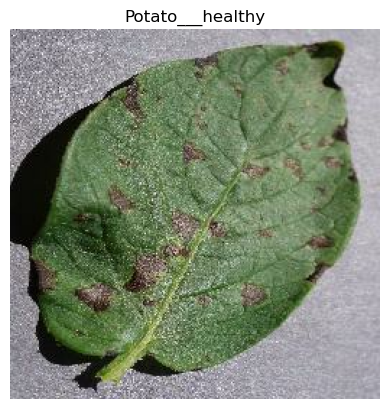

In [23]:
for image_batch,label_batch in dataset.take(2):
    plt.title(class_names[label_batch[3]])
    plt.imshow(image_batch[2].numpy().astype("uint8"))
    plt.axis("off")

In [24]:
#taking 54 batches
train_ds=dataset.take(54)

In [7]:
test_ds=dataset.skip(54) 

In [8]:
val_ds=test_ds.take(6)
test_ds=test_ds.skip(6)

In [9]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
        ds_size=len(ds)
        
        if shuffle:
            ds=ds.shuffle(shuffle_size,seed=12)
        
        train_size=int(train_split*ds_size)
        val_size=int(val_split*ds_size)
        
        train_ds=ds.take(train_size)
        val_ds=ds.skip(train_size).take(val_size)
        test_ds=ds.skip(train_size).skip(val_size)
        
        return train_ds,val_ds,test_ds

In [10]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [11]:
len(train_ds)

54

In [12]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])


In [14]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,channels)
n_classes=3

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [27]:
history=model.fit(
    train_ds,
    epochs=10,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)
print(EPOCHS)

Epoch 1/10
54/54 [==============================] - 39s 713ms/step - loss: 0.1726 - accuracy: 0.9334 - val_loss: 0.1870 - val_accuracy: 0.9479
Epoch 2/10
54/54 [==============================] - 41s 764ms/step - loss: 0.1533 - accuracy: 0.9444 - val_loss: 0.1960 - val_accuracy: 0.9167
Epoch 3/10
54/54 [==============================] - 39s 726ms/step - loss: 0.1376 - accuracy: 0.9502 - val_loss: 0.1494 - val_accuracy: 0.9271
Epoch 4/10
54/54 [==============================] - 38s 704ms/step - loss: 0.0963 - accuracy: 0.9601 - val_loss: 0.3445 - val_accuracy: 0.8958
Epoch 5/10
54/54 [==============================] - 78s 1s/step - loss: 0.0885 - accuracy: 0.9659 - val_loss: 0.1698 - val_accuracy: 0.9479
Epoch 6/10
54/54 [==============================] - 78s 1s/step - loss: 0.1399 - accuracy: 0.9537 - val_loss: 0.2651 - val_accuracy: 0.8698
Epoch 7/10
54/54 [==============================] - 71s 1s/step - loss: 0.1204 - accuracy: 0.9531 - val_loss: 0.1112 - val_accuracy: 0.9635
Epoch 8/

In [29]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 2s 265ms/step - loss: 0.1975 - accuracy: 0.9336


In [26]:
model.predict(test_ds[0])

TypeError: '_PrefetchDataset' object is not subscriptable

first image to predict
first image actual label: Potato___Late_blight
1/1 [==============================] - 0s 174ms/step
Potato___Late_blight


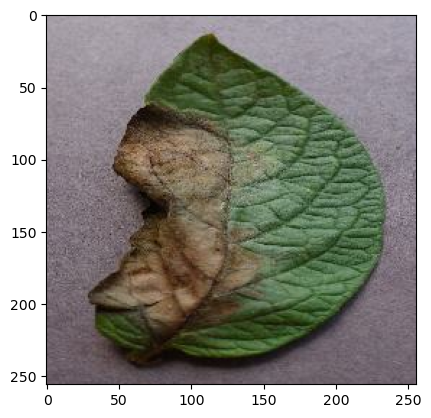

In [34]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_img=images_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_img)
    print("first image actual label:",class_names[first_label])
    
    batch_predict=model.predict(image_batch)
    print(class_names[np.argmax(batch_predict[0])])

In [45]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
    
    predict_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*np.argmax(predictions[0]),2)
    return predict_class,confidence

1/1 [==============================] - 0s 38ms/step


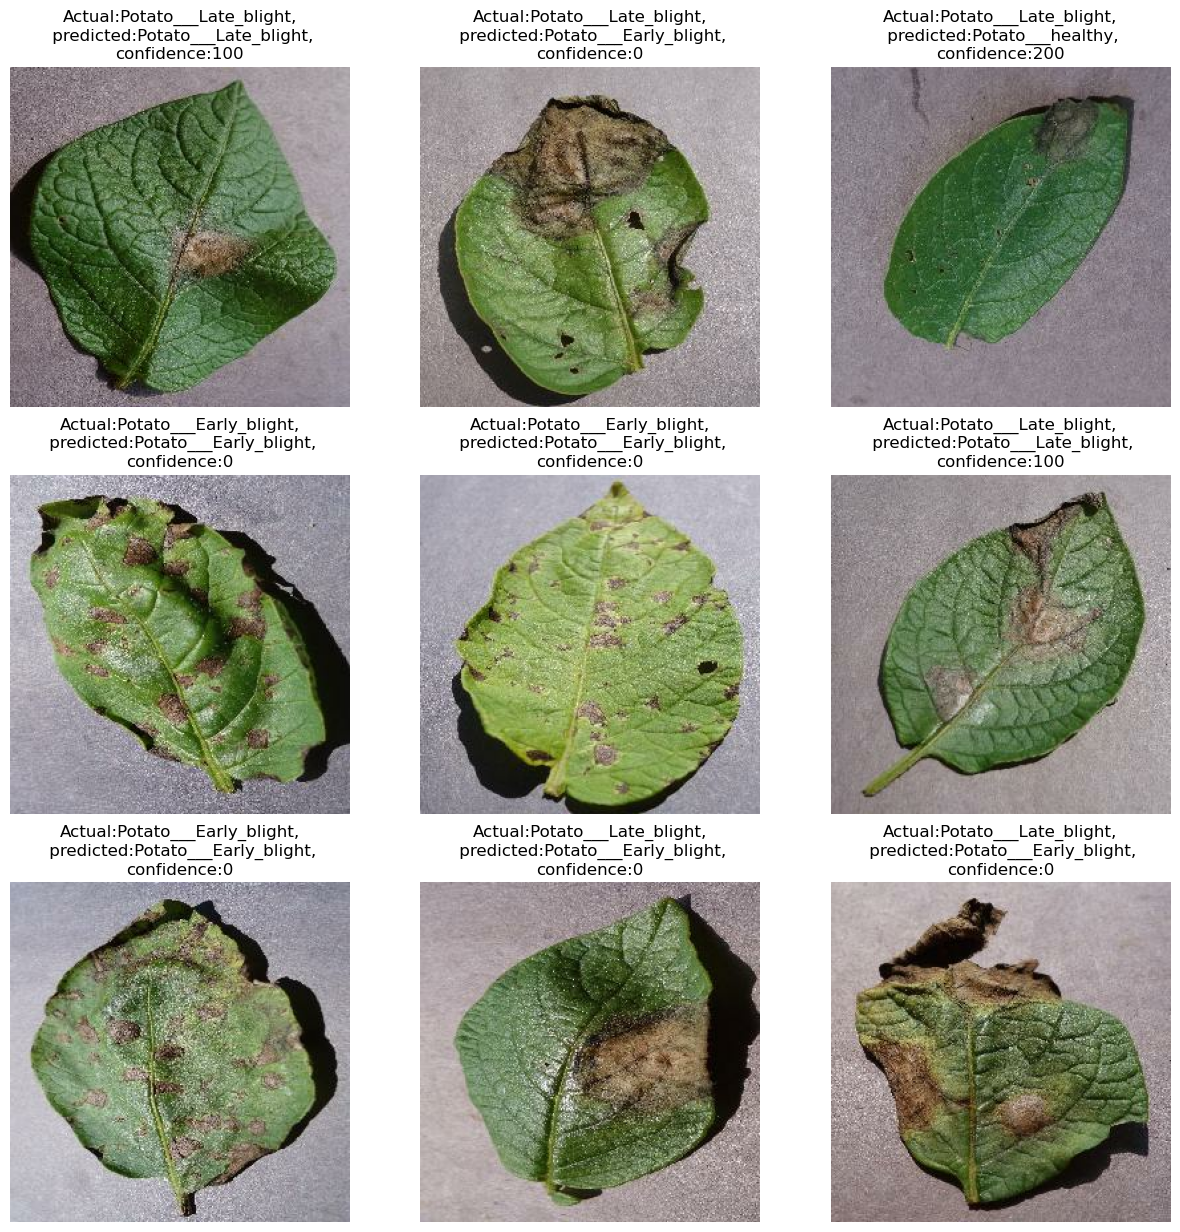

In [49]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\n predicted:{predicted_class},\nconfidence:{confidence}")
        plt.axis("off")